In [1]:
%matplotlib inline

In [2]:
!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

Downloading...
From: https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR
To: /content/cifar.npz
185MB [00:03, 55.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU
To: /content/mnist.npz
55.4MB [00:00, 151MB/s]


In [3]:
import os
import re

import httpimport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.utils.data
from torch import nn
import torch.nn.functional as F

# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat
        
sns.set_style('whitegrid')

def n(t):
    return t.detach().cpu().numpy()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# The variational autoencoder (VAE, [Kingma 2014](https://arxiv.org/abs/1312.6114))

The VAE is a latent variable model able to learn difficult probability distributions, such as generating MNIST images. 

We will assume that data samples are generated in a two step process:
1. Sample a latent code $z$ from prior $p_\theta(z)$, such as a multivariate standard normal.
2. Sample $x$ from $p_\theta(x|z) = \mathcal{N}(\mu=d_\theta(z), \sigma)$  and $d_\theta(z)$ is a complicated, learned transformation function typically implemented using a neural network.

In other words, the VAE generates samples from a complicated distribution $p_\theta(x)=p_\theta(x|z)p_\theta(z)$ by sampling from a simple probability distribution, followed by a highly nonlinear transformation.

## Intuitions
For instance, assume that $d(z) = z/10 + z/||z||$. The transformed variables lie close to a unit circle, a more complicated distribution than a standard normal.


Text(0.5, 1.0, 'x = d(z)')

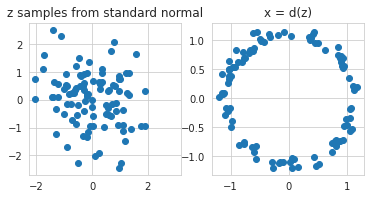

In [4]:
z = np.random.randn(2,100)  # z is standard normal

def d(z):
    return z/10 + z/np.linalg.norm(z, axis=0, keepdims=True)

x = d(z)

plt.subplot(121)
plt.scatter(z[0,:], z[1,:])
plt.axis('square')
plt.title('z samples from standard normal')

plt.subplot(122)
plt.scatter(x[0,:], x[1,:])
plt.axis('square')
plt.title('x = d(z)')

Please note, that the posterior distribution $p_\theta(z|x)$ is often impossible to compute:

$$
p_\theta(z|x) = \frac{p_\theta(x|z)p_\theta(z)}{\int_{z'}p_\theta(x|z')p_\theta(z')dz}
$$

To derive a trainig objective for the VAE we will introduce an approximate distribution $q_\phi(z|x)$ that is easy to compute, but may not be accurate. In fact, $q_\phi(z|x)$ is often parameterized as another neural computation, which returns both the mean and standard deviation of a normal distribution:   $q_\phi(z|x) = \mathcal{N}([\mu, \sigma] =e_\phi(x))$.

We will derive a similar bound for the log-likelihood as we did in the EM case:

\begin{equation}
\begin{split}
KL(q_\phi(z|x) || p_\theta(z|x)) &= \mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log\frac{p_\theta(z|x)}{q_\phi(z|x)}\right]= \\
&=\mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log\frac{p_\theta(z|x)p_\theta(x)}{q_\phi(z|x)p_\theta(x)}\right]= \\
&=\mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log\frac{p_\theta(z|x)p_\theta(x)}{q_\phi(z|x)}\right] + \mathbb{E}_{z\sim q_\phi(z|x)}\left[\log p_\theta(x)\right] = \\
&=\mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log\frac{p_\theta(x,z)}{q_\phi(z|x)}\right] +\log p_\theta(x) 
\end{split}
\end{equation}

Thus
$$
\log p_\theta(x)  = KL(q_\phi(z|x) || p_\theta(z|x)) + \mathbb{E}_{z\sim q_\phi(z|x)}\left[\log\frac{p_\theta(x,z)}{q_\phi(z|x)}\right].
$$

Since $KL(\cdot||\cdot)\geq 0$, we get
\begin{equation}
\begin{split}
\log p_\theta(x)  &\geq \mathbb{E}_{z\sim q_\phi(z|x)}\left[\log\frac{p_\theta(x,z)}{q_\phi(z|x)}\right] = \\
&= \mathbb{E}_{z\sim q_\phi(z|x)}\left[\log\frac{p_\theta(x|z)p_\theta(z)}{q_\phi(z|x)}\right] = \\
&=\mathbb{E}_{z\sim q_\phi(z|x)}\left[\log p_\theta(x|z)\right] - \mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log\frac{p_\theta(z)}{q_\phi(z|x)}\right] \\
&=\mathbb{E}_{z\sim q_\phi(z|x)}\left[\log p_\theta(x|z)\right] - KL(q_\phi(z|x) || p_\theta(z))
\end{split}
\end{equation}

We call this form the Evidence Lower Bound (ELBO), because for any $q(z|x)$ it gives us a lower bound on the log-likelihood of a data sample.

The two terms of ELBO have an intuitive meaning:
1. $\mathbb{E}_{z\sim q_\phi(z|x)}\left[\log p_\theta(x|z)\right] = \int_z q_\phi(z|x) p_\theta(x|z) dz$ is the log-likelihood of samples generated in a two-step process in which we first zample a $z$ from the approximating distribution $q$, then sample $x$.
2. $- KL(q_\phi(z|x) || p_\theta(z))$ gives the mismatch between the approximatio $q_\phi(z|x)$ and the prior $p_\theta(z)$. The larger the divergence, the more information about $x$ we encode in the $q$ distribution. 

Intuitively, the ELBO is large when we:
1. properly reconstruct $x$
2. transferring the minimal amount of information in $q\phi(z|x)$.

## Optimizing the ELBO
Im machine learning we are used to minimizing loss fnuctions. The negation of the ELBO gives us:
$$
-\log p_\theta(x) \leq \mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log p_\theta(x|z)\right] + KL(q_\phi(z|x) || p_\theta(z))
$$
which states that our training objective is to minimize the negative log-likelihood of the reconstructed data (reconstruction loss), augmented with a penalty on the latent code expressed as the KL from a simple prior distribution. The more specific the approximate posterior $q_\phi(z|x)$, the more penalty the model pays.

We will train our model by minimizing this upper bound on the negative log likelihood using gradient methods. For a Gaussian prior $p_\theta(z)$ and Gaussian approximate posterior $q_\phi(z|x)$ the KL-term can be computed and differentiated analytically.

Computing gradients of the reconstruction loss is more involved. We will first replace the expected value with a Monte Carlo estimation that uses $m$ samples:

$$
\mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log p_\theta(x|z)\right] \approx 
\frac{1}{m}\sum_{i=1}^m -\log p_\theta(x|z_i),\qquad\text{where } z_i \sim q_\phi(z|x).
$$

This is however not enough, because we will want to optimize the approximating distribution $q$ over its parameters $\phi$, however we can't differentiate through the sampling operation.

We will therefore introduce a reparameterization: instead of sampling from $q_\phi(z|x) = \mathcal{N}([\mu, \sigma] =e_\phi(x))$ we will sample from a standard normal, then shift and scale by the parameters given by e_\phi(x).

Let $[\mu, \sigma] =e_\phi(x)$. Then
$$
\mathbb{E}_{z\sim q_\phi(z|x)}\left[-\log p_\theta(x|z)\right] \approx 
\frac{1}{m}\sum_{i=1}^m -\log p_\theta(x|z=\epsilon_i \cdot \sigma + \mu),\qquad\text{where } \epsilon_i \sim \mathcal{N}(0,1).
$$

Finally, this form allows to backpropagate the loss gradient to the parameters of $q$, i.e. to the $e_\phi()$ neural network.

## VAE as an autoencoder

The VAE involves two neural networks:
1. The $e_\phi()$ specifies the parameters of a distribution onver the latents, $z$, given a data sample $x$. It thus acts as an encoder
2. Conversely, $d_\theta()$ reconstructs $x$ based on a sample $z$. Thus it acts as a decoder. 

Thus the VAE can be seen as a probabilitisc autoencoder, which assigns, for each data sample, a probability distribution over latents. Reconstructions are probabilistic, too -- we can sample several reconstructions of a single data sample.

Training the VAE optimizes the ELBO criterion, composed of two terms: the first wants to make good reconstructions, this is similar to other autoencoders. The second term penalizes the amount of information that the VAE carries about the data sample in its latent code. Thus it can be seen as an information-bottleneck auoencoder in which, instead of enforcing latent code dimensionality or sparsity, we limit the amount of information that it carries.

However, unlike regilar autoencoders the VAE is aprobabilistic model, which allows generatin new data points. To do so, We only need to know the assumed prior distribution $p_\theta(z)$ and the trained decoder $p_\theta(x|z)$.

# VAE implementation and demo

In [5]:
with np.load('mnist.npz') as data:
    mnist_full_train_data = data['train_data'].astype('float32') / 255.0
    mnist_full_train_labels = data['train_labels']
    mnist_test_data = data['test_data'].astype('float32') / 255.0
    mnist_test_labels = data['test_labels']

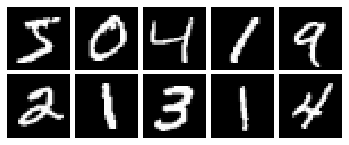

In [6]:
plot_mat(mnist_full_train_data[:10, None], cmap='gray')

In [7]:
class InMemDataLoader(object):
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        tensors = [torch.tensor(tensor) for tensor in tensors]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

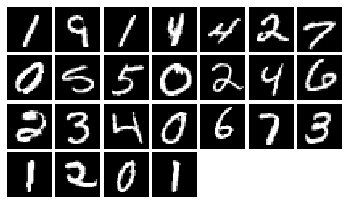

In [8]:
train_loader = InMemDataLoader(
    (mnist_full_train_data, ), batch_size=25, shuffle=True)
test_loader = InMemDataLoader(
    (mnist_test_data, ), batch_size=100, shuffle=False)

batch_x, = next(iter(train_loader))
plot_mat(batch_x.numpy()[:,None,:,:], cmap='gray')

In [9]:
# Hyperparams

inp_dim = batch_x.shape[1:]
enc_dim = 500
latent_dim = 2

class Encoder(torch.nn.Module):
    """Takes an image and produces a latent vector."""
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(np.prod(inp_dim), enc_dim)
        self.fc2 = nn.Linear(enc_dim, enc_dim)
        #
        # Return 2 * latent_dim, i.e. the means and std devs!
        #
        self.fc3 = nn.Linear(enc_dim, 2 * latent_dim)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.split(x, latent_dim, dim=-1)    

class Decoder(torch.nn.Module):
    """Takes an image and produces a latent vector."""
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, enc_dim)
        self.fc2 = nn.Linear(enc_dim, enc_dim)
        self.fc3 = nn.Linear(enc_dim, np.prod(inp_dim))
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def reparameterize(self, z_mean, z_log_sigma2):
        z_sigma = torch.exp(0.5 * z_log_sigma2)
        epsilon = torch.randn_like(z_mean)
        epsilon.mul_(z_sigma)
        epsilon.add_(z_mean)
        return epsilon
    
    def forward(self, x):
        z_mean, z_log_sigma2 = self.encoder(x)
        z = self.reparameterize(z_mean, z_log_sigma2)
        reconstruction = self.decoder(z).view(x.size())
        return reconstruction, z_mean, z_log_sigma2
        
def elbo_loss(x, reconstruction, z_mean, z_log_sigma2, beta=1.0):
    N = x.size(0)
    rec_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum') / N
    KL_loss = (-0.5 / N) * (
        torch.sum(1.0 + z_log_sigma2 - z_mean.pow(2) - z_log_sigma2.exp()))

    return (rec_loss + beta * KL_loss,
            {'rec_loss': rec_loss.item(), 'KL_loss': KL_loss.item()})


In [10]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1.0e-5)
global_step = 0

## VAE training dynamics

In the cell belo we train the VAE.

Please note, that while the global loss is decreasing (upper bound on the negative log likelihood is getting smaller), the two terms that make the loss have a more complicated dynamics. At the beginning, the KL term is close to zero, meaning that the VAE carries no information about $x$ through the latent code $z$. Then, the KL term increases ($z$ begin to encode information about $x$). This causes a drastic reduction of the reconstruction loss, which results on an overall decline of the total loss.



In [11]:
model.train()

model.to('cuda')
train_loader.to('cuda')

for epoch in range(100):
    for inum, (batch_x, ) in enumerate(train_loader):
        global_step += 1
        optimizer.zero_grad()
        reconstruction, mu, sigma2 = model(batch_x)
        loss, stats = elbo_loss(batch_x, reconstruction, mu, sigma2, beta=1.0)
        loss.backward()
        optimizer.step()
        if (global_step%1000) == 1:
            print("global step: %d (epoch: %d, step: %d), loss: %f %s" % 
                  (global_step, epoch, inum, loss.item(), stats))

global step: 1 (epoch: 0, step: 0), loss: 543.315491 {'rec_loss': 543.3111572265625, 'KL_loss': 0.004328603856265545}
global step: 1001 (epoch: 0, step: 1000), loss: 167.437683 {'rec_loss': 163.60646057128906, 'KL_loss': 3.8312292098999023}
global step: 2001 (epoch: 0, step: 2000), loss: 175.880539 {'rec_loss': 171.69223022460938, 'KL_loss': 4.188302040100098}
global step: 3001 (epoch: 1, step: 600), loss: 172.123840 {'rec_loss': 168.1192169189453, 'KL_loss': 4.00462007522583}
global step: 4001 (epoch: 1, step: 1600), loss: 168.143677 {'rec_loss': 163.8448944091797, 'KL_loss': 4.298789978027344}
global step: 5001 (epoch: 2, step: 200), loss: 165.011093 {'rec_loss': 160.15060424804688, 'KL_loss': 4.860489845275879}
global step: 6001 (epoch: 2, step: 1200), loss: 149.492035 {'rec_loss': 144.3890838623047, 'KL_loss': 5.102957248687744}
global step: 7001 (epoch: 2, step: 2200), loss: 137.139633 {'rec_loss': 131.0590362548828, 'KL_loss': 6.080597400665283}
global step: 8001 (epoch: 3, step:

## VAE analysis

Text(0.5, 1.0, 'Reconstructions from multiple latent samples')

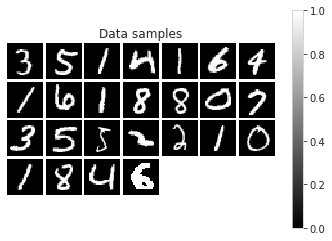

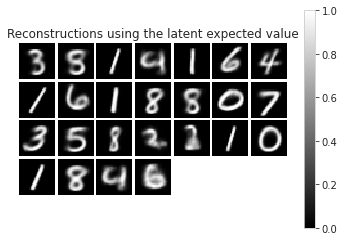

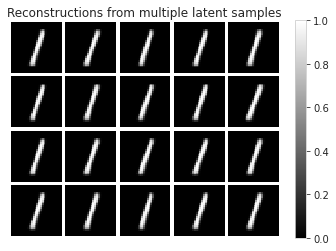

In [12]:
# In this cell we look at the VAE from the autoencoder perspective.
# We see how well it can reconstruct the input data and,
# given its probablilistic nature, how variable are the reconstructions
# when several zs are samples from q(z|x).
#

model.eval()
batch_x = next(iter(train_loader))[0]
with torch.no_grad():
    reconstruction, mu, sigma2 = model(batch_x)


plot_mat(n(batch_x)[:,None,:,:], cmap='gray')
plt.colorbar()
plt.title('Data samples')


reconstruction_from_mean = model.decoder(mu).view(batch_x.size())
plt.figure()
plot_mat(n(reconstruction_from_mean)[:, None, :, :], cmap='gray')
plt.colorbar()
plt.title('Reconstructions using the latent expected value')

same_x = batch_x[2:3].repeat(20, 1, 1)
same_recs, _, _ = model(same_x)
plt.figure()
plot_mat(n(same_recs)[:, None, :, :], cmap='gray')
plt.colorbar()
plt.title('Reconstructions from multiple latent samples')

Text(0.5, 1.0, 'interpolation between two samples')

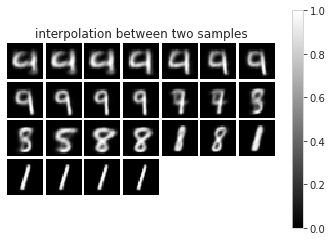

In [13]:
# Here we make an interpolation in the latent space: we take two samples and 
# find their latent codes. We then connect the codes using a straigth line,
# and plot reconstruction as we moove through this line.

interp_weights = torch.linspace(
    0.0, 1.0, steps=25, dtype=torch.float32, device=batch_x.device).view(-1, 1)
k1, k2 = 2, 3
interp_mu = interp_weights * mu[k1] + (1.0 - interp_weights) * mu[k2]
interp_sigma2 = interp_weights * sigma2[k1] + (1.0 - interp_weights) * sigma2[k2]
interp_recs = model.decoder(
    model.reparameterize(interp_mu, interp_sigma2)).view(-1, 1, 28, 28)

plt.figure()
plot_mat(n(interp_recs), cmap='gray')
plt.colorbar()
plt.title('interpolation between two samples')

Text(0.5, 1.0, 'Samples from a 2dimensional VAE')

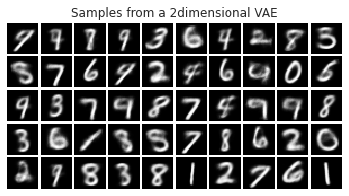

In [14]:
# Finally, we can loook at samples generated using a VAE
#

z_rand = torch.randn(50, latent_dim, device=batch_x.device, dtype=batch_x.dtype)
samples = model.decoder(z_rand).view(-1, 1, batch_x.size(1), batch_x.size(2))
plot_mat(n(samples), cmap='gray')
plt.title("Samples from a %ddimensional VAE" % latent_dim)

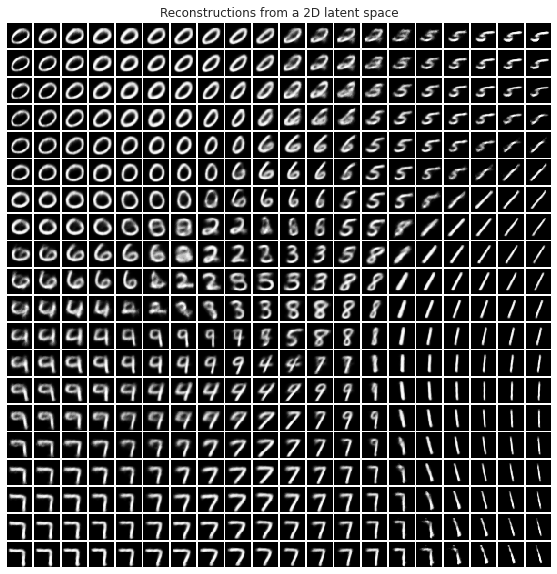

In [15]:
# Finally, for a 2D latent space, we can draw images that are generated from 
# a grid over the two latent dimensions.
#

if latent_dim == 2:
    plt.figure(figsize=(10, 10))
    z_mesh_x, z_mesh_y = np.meshgrid(np.linspace(-3, 3, 20), np.linspace(-3, 3, 20))
    z_mesh = np.concatenate([z_mesh_x.reshape(-1, 1), 
                             z_mesh_y.reshape(-1, 1)], axis=1)

    mesh = model.decoder(torch.tensor(z_mesh, dtype=torch.float32, device=batch_x.device)).view(-1, 1, 28, 28)
    plot_mat(n(mesh), prop=(1,1), cmap='gray')
    plt.title('Reconstructions from a 2D latent space')